In [2]:
import numpy as np
import platform
import time
from itertools import islice, cycle

# This fixes NSInvalidArgumentException from tkinter on OSX
if platform.system() == "Darwin": 
    import matplotlib
    matplotlib.use("NbAgg")
    from matplotlib import pyplot as plt
else:
    import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D    
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn import cluster
import sklearn as skl

import curve_fitting


In [3]:
# Fit all polarity csvs with 8th degree polynomial
# and store coefficients in dictionary

polyfit_dict = curve_fitting.polyfit(8)

In [4]:
authors = [key for key, val in polyfit_dict.items()]
print(len(authors))

139


/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


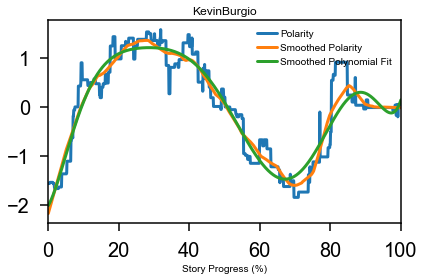

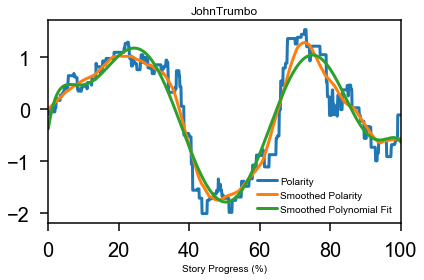

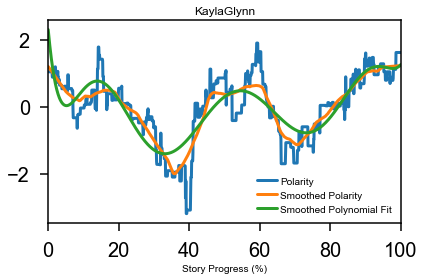

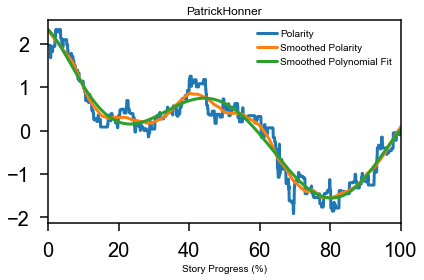

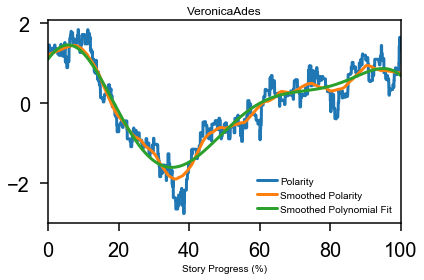

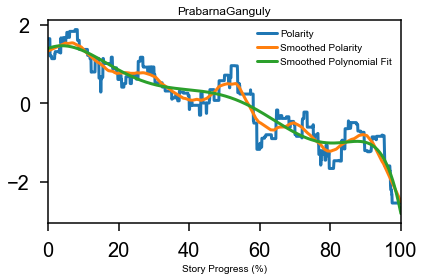

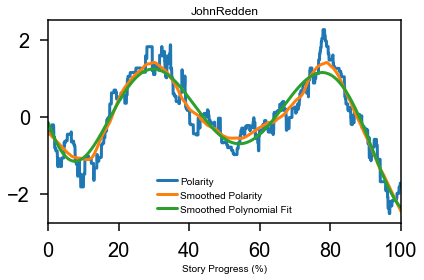

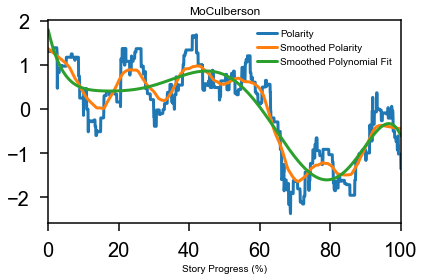

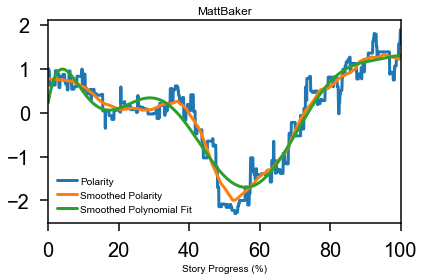

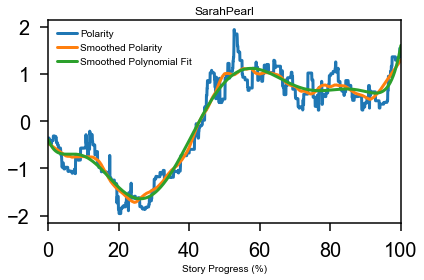

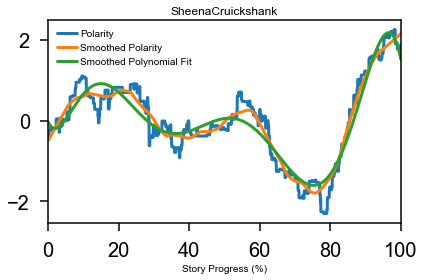

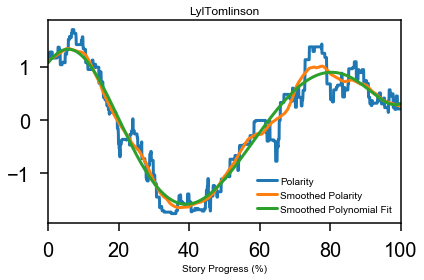

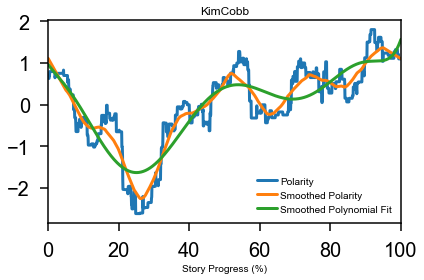

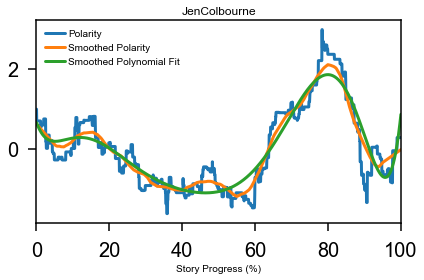

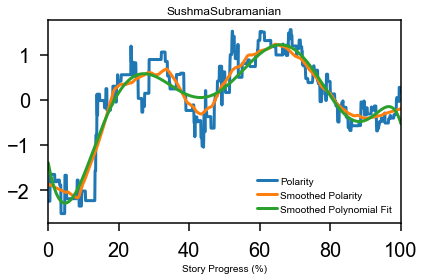

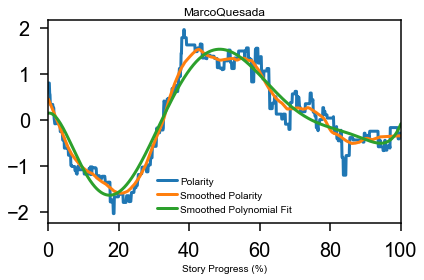

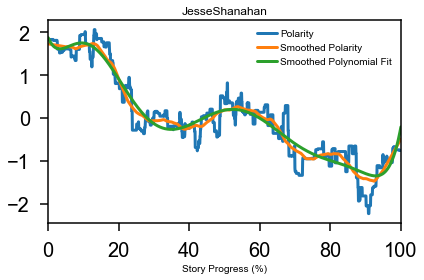

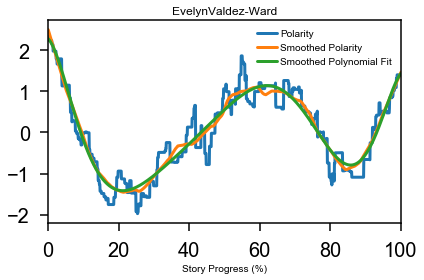

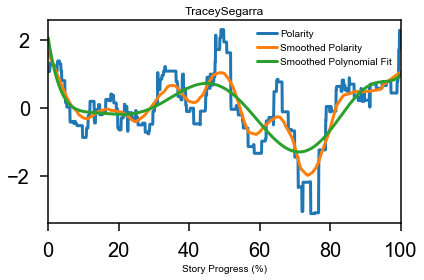

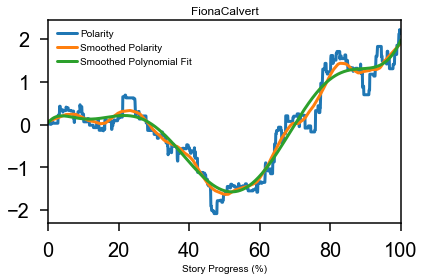

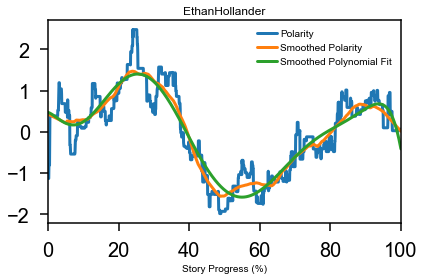

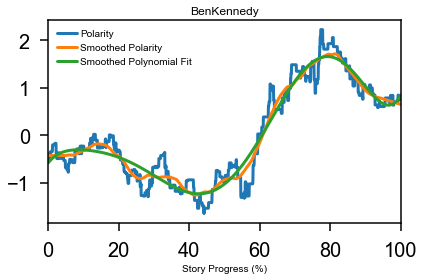

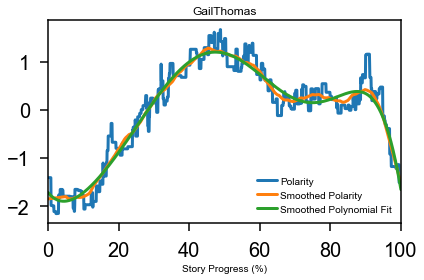

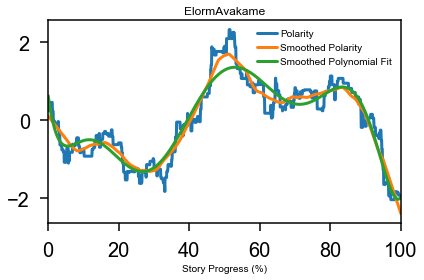

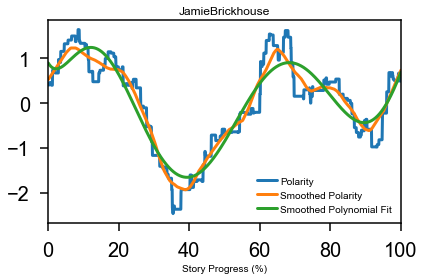

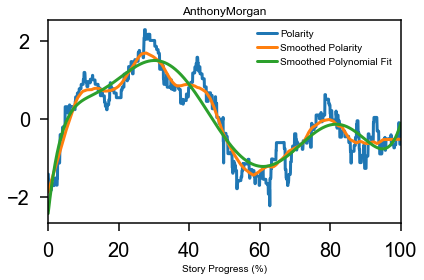

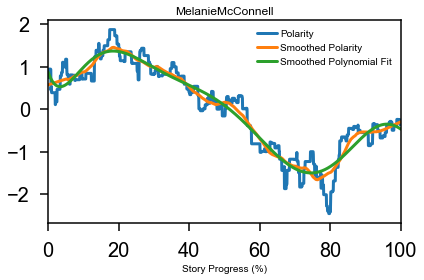

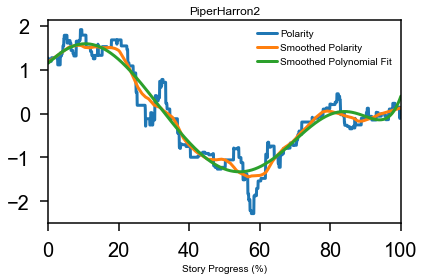

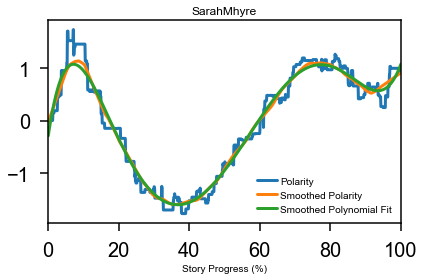

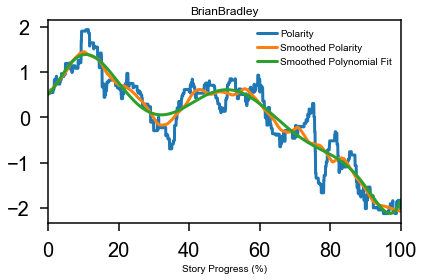

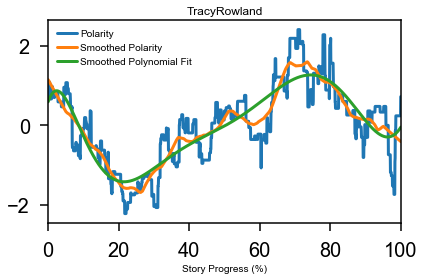

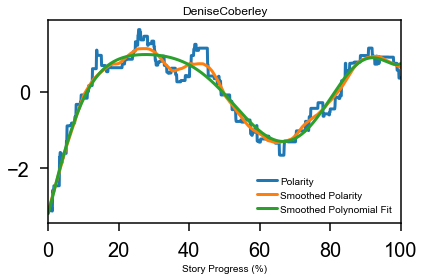

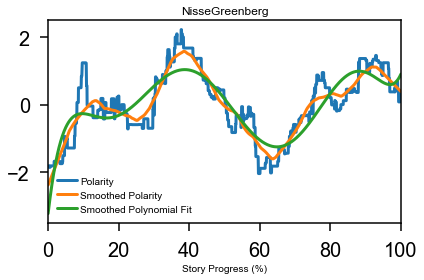

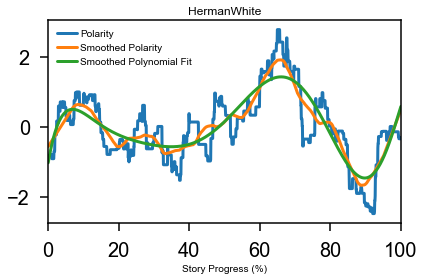

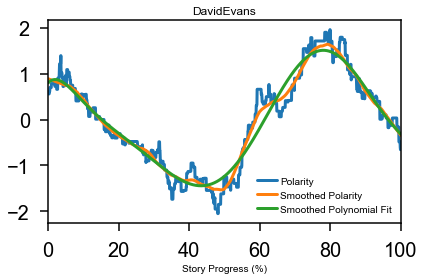

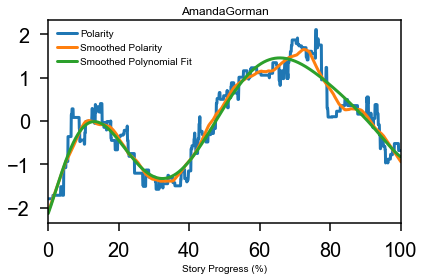

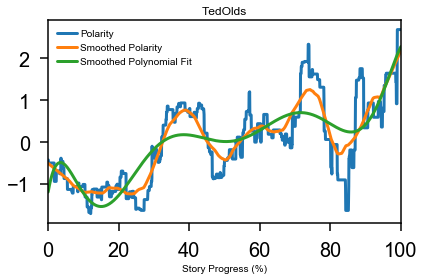

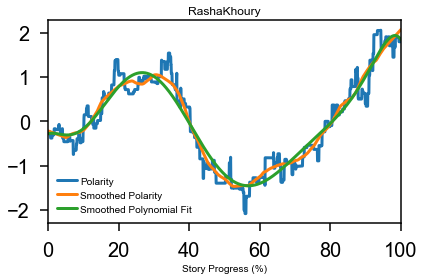

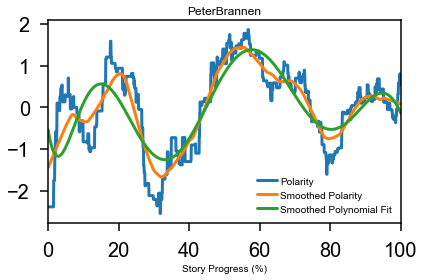

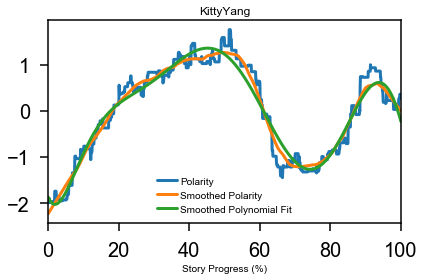

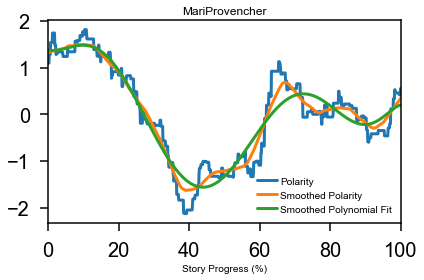

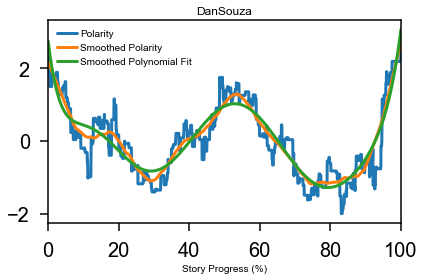

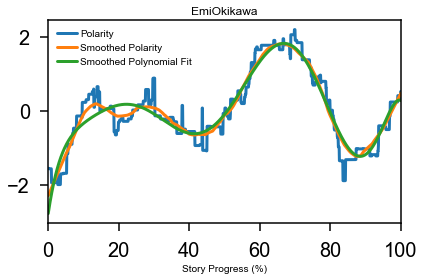

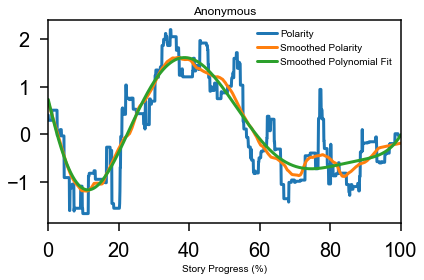

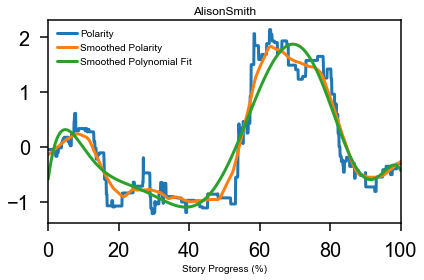

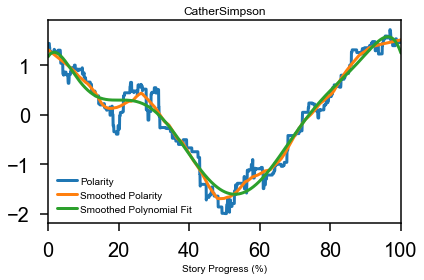

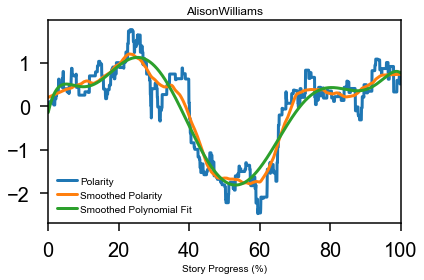

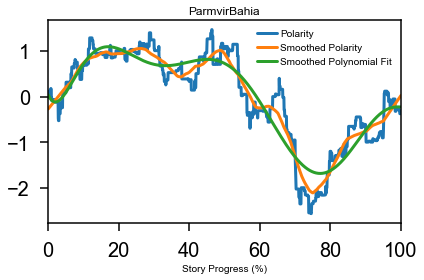

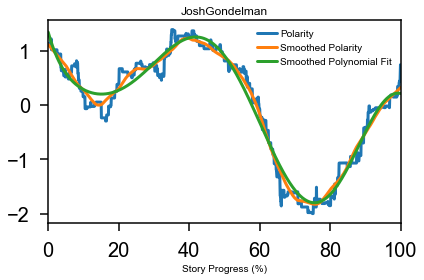

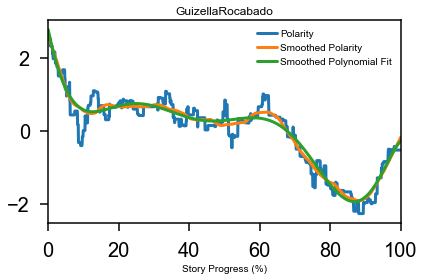

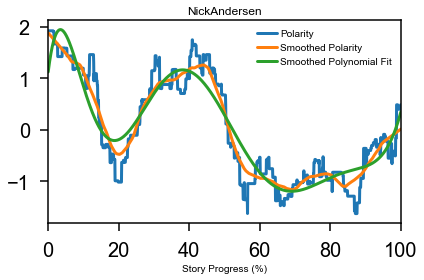

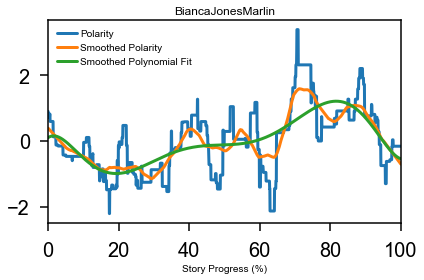

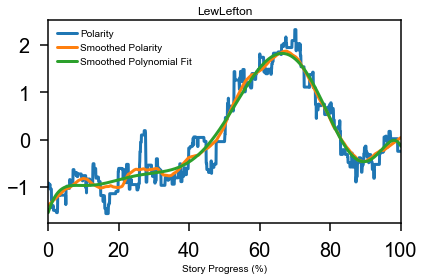

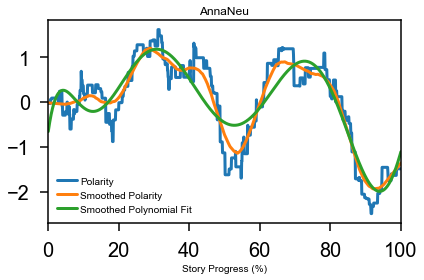

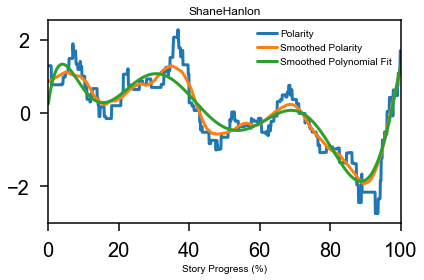

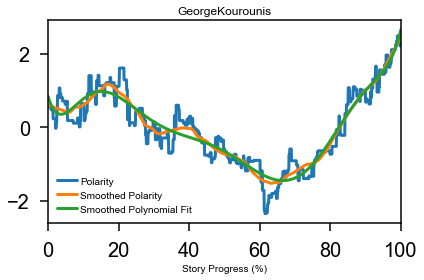

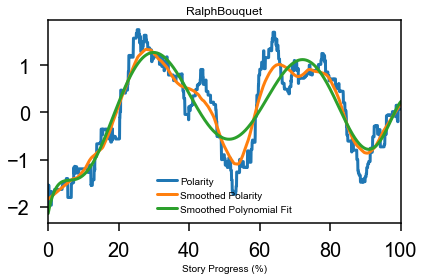

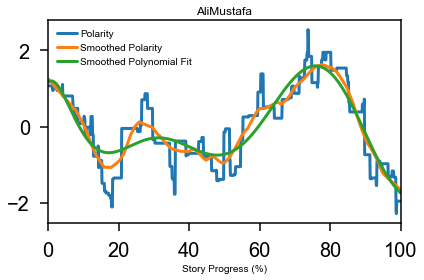

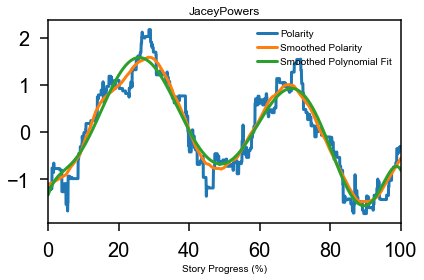

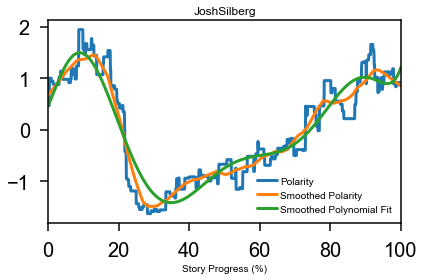

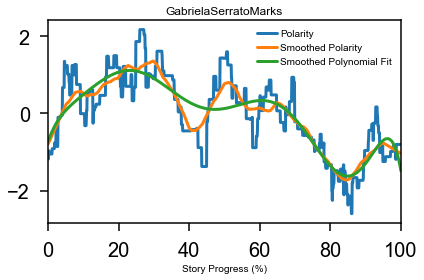

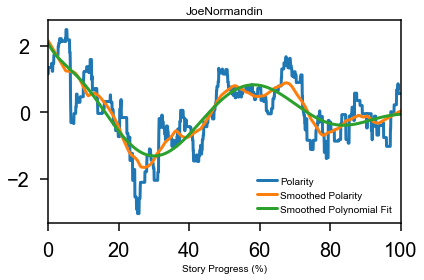

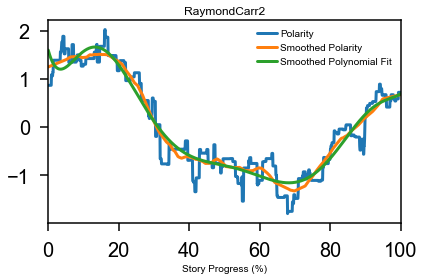

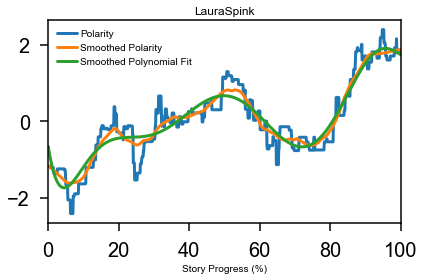

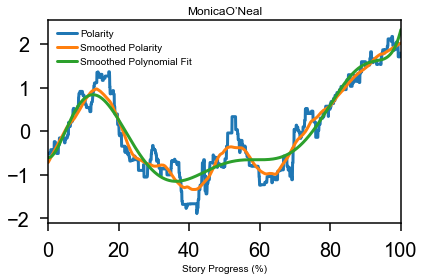

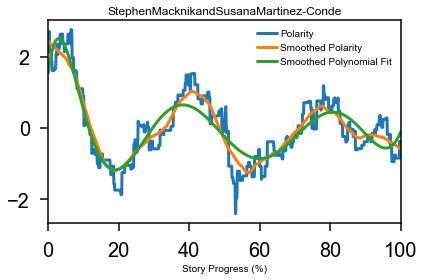

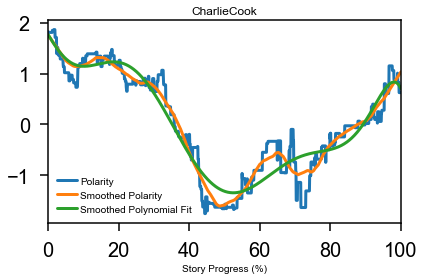

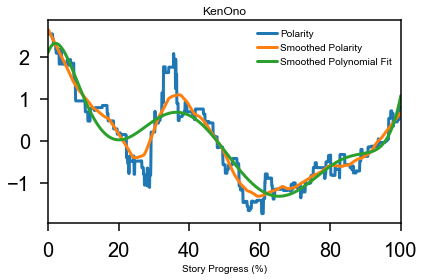

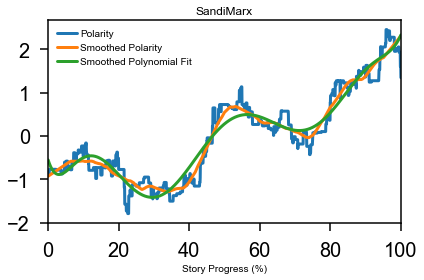

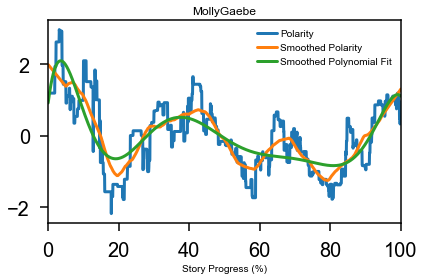

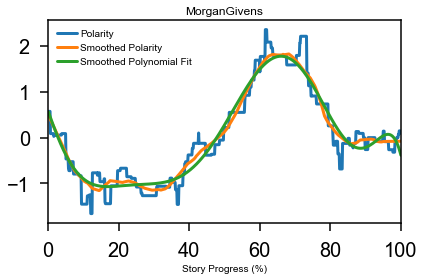

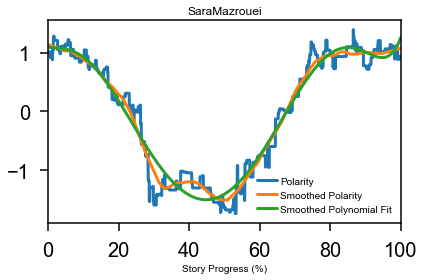

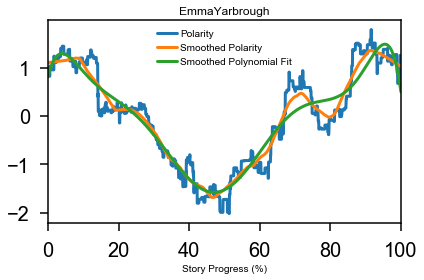

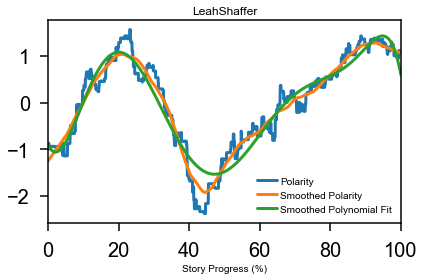

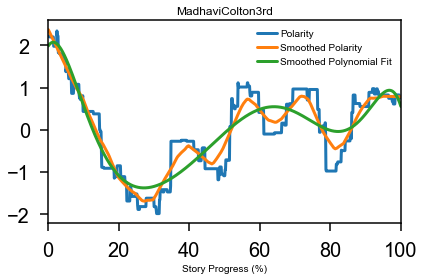

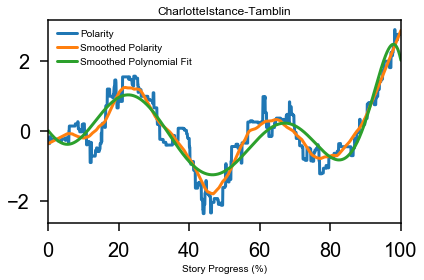

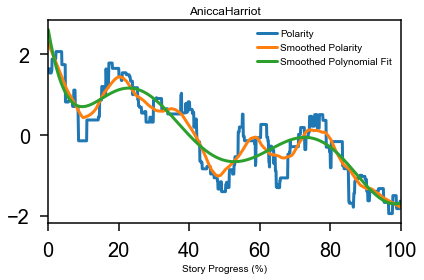

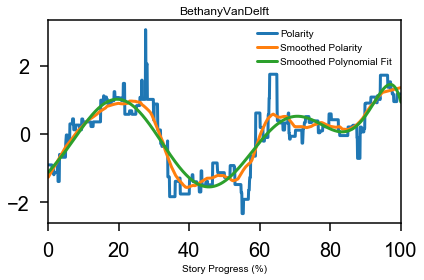

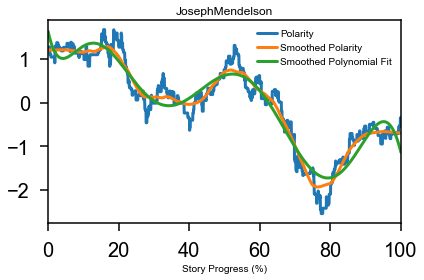

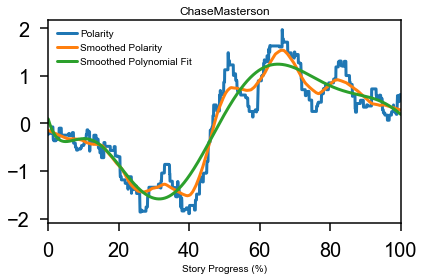

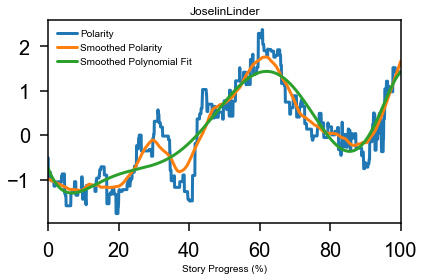

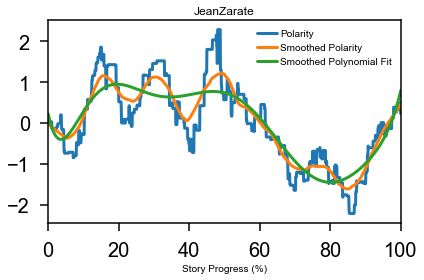

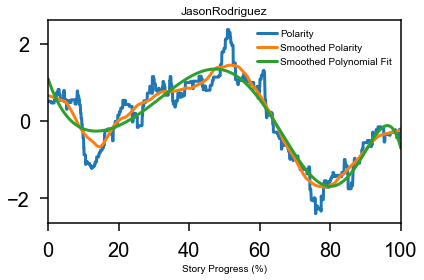

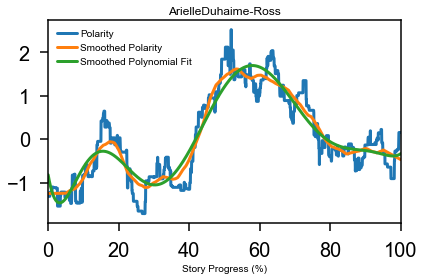

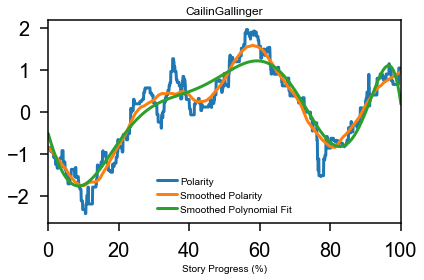

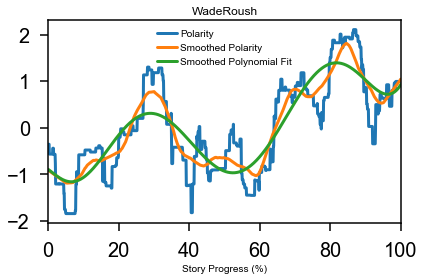

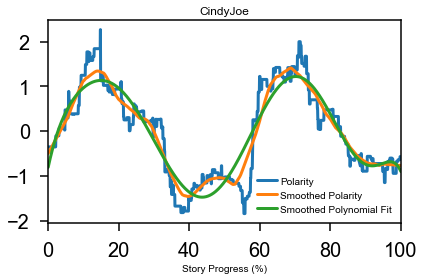

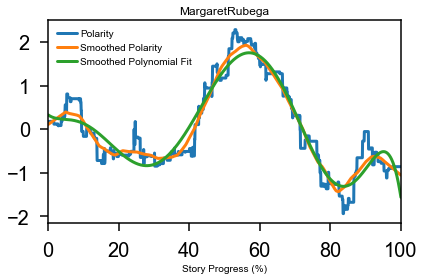

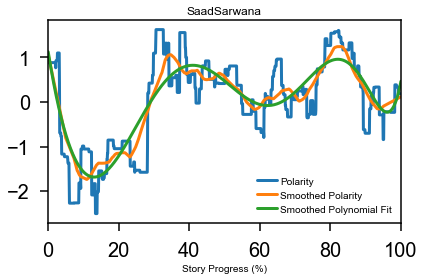

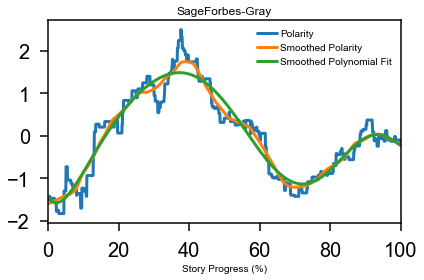

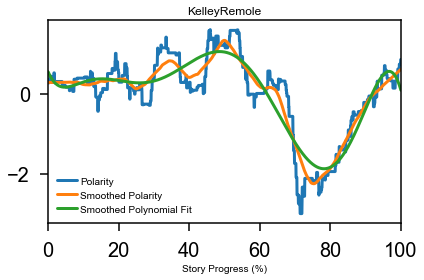

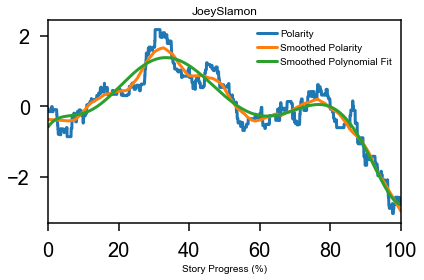

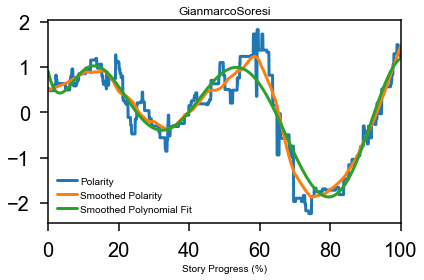

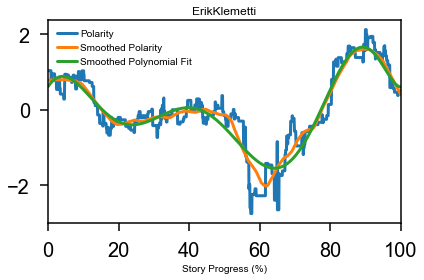

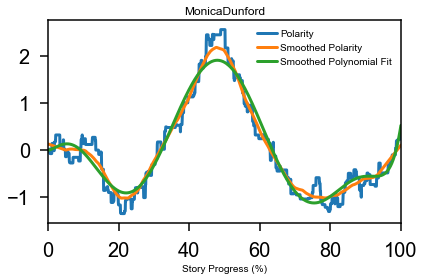

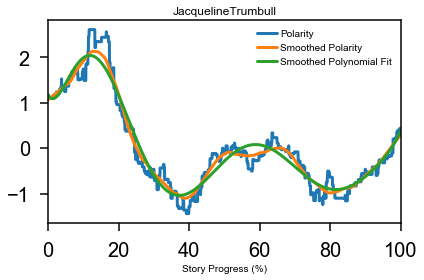

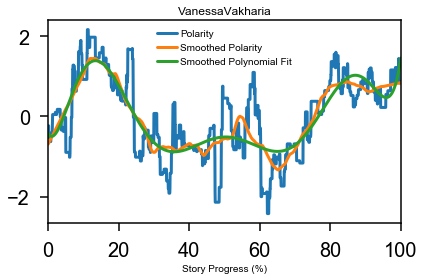

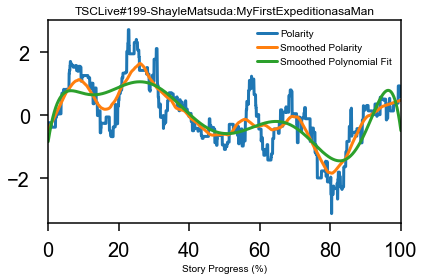

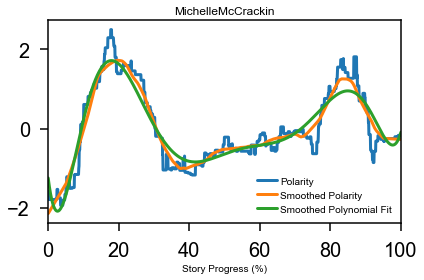

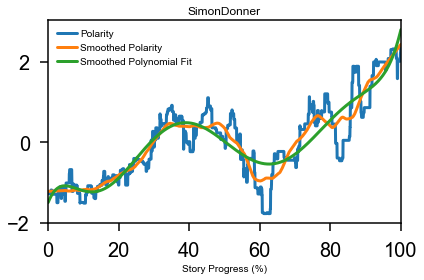

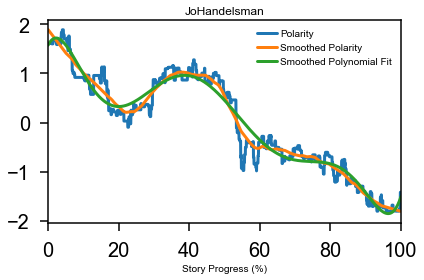

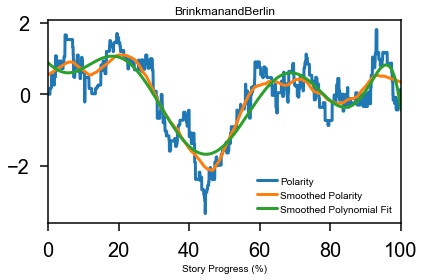

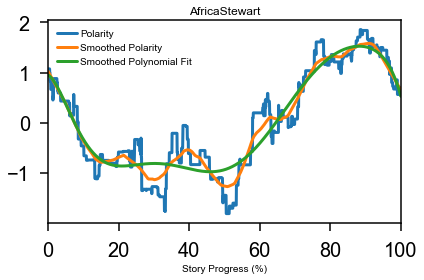

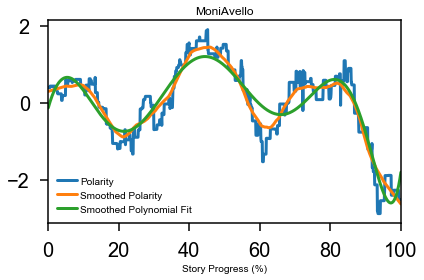

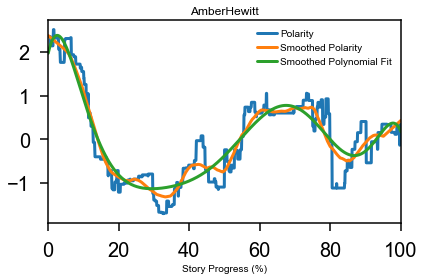

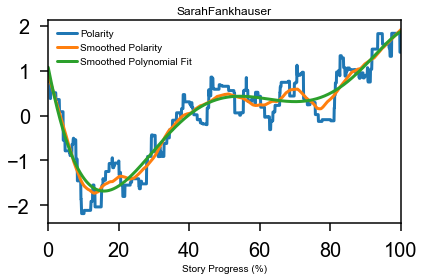

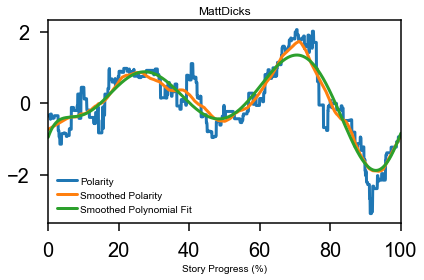

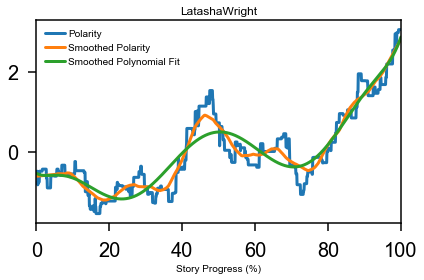

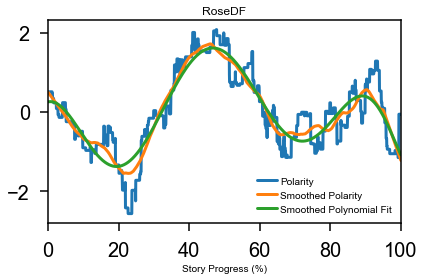

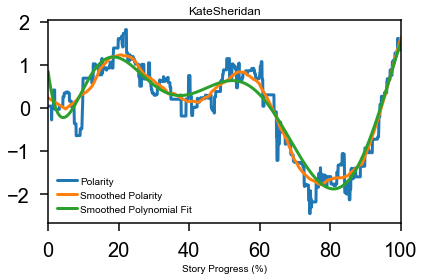

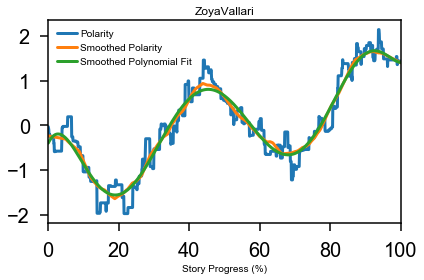

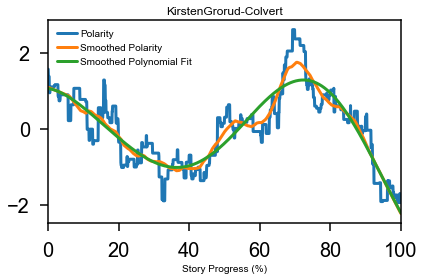

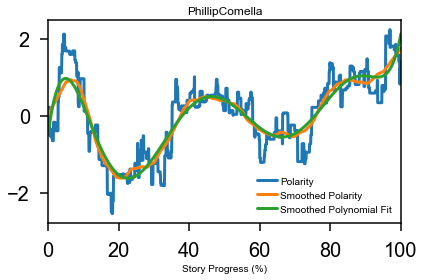

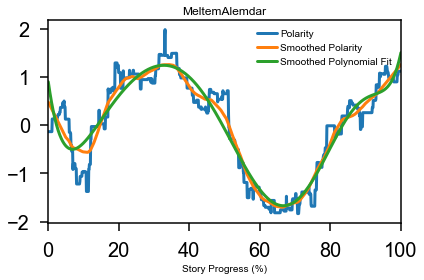

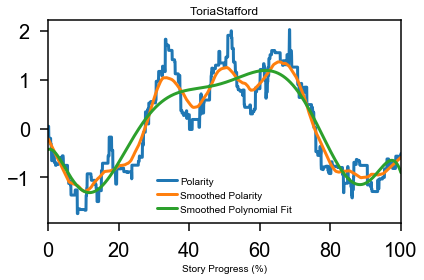

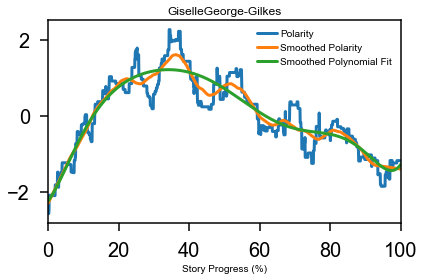

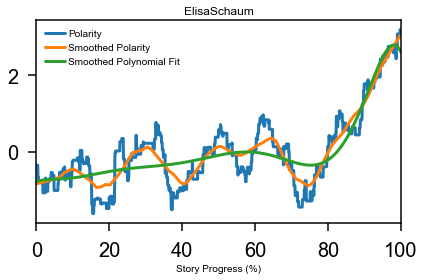

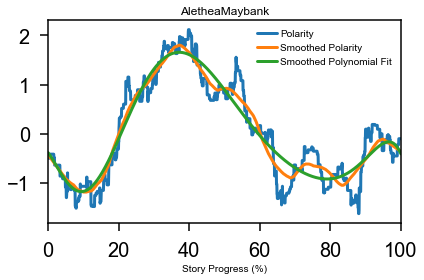

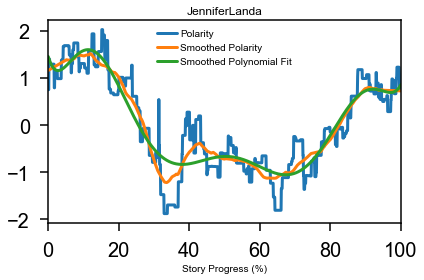

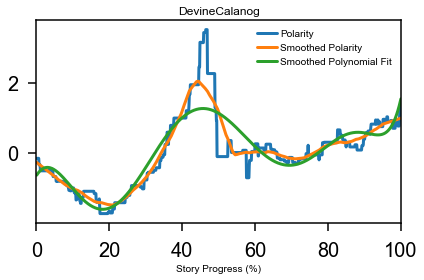

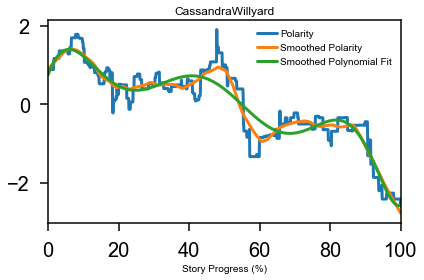

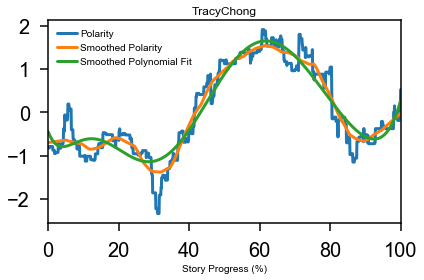

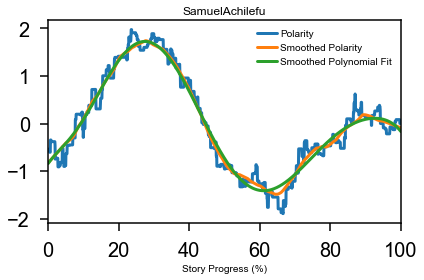

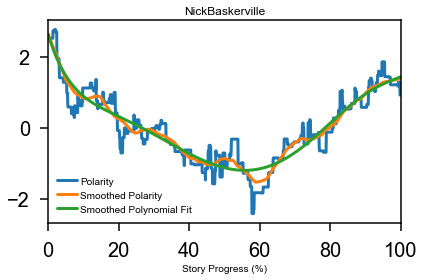

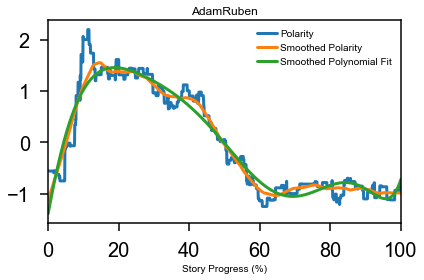

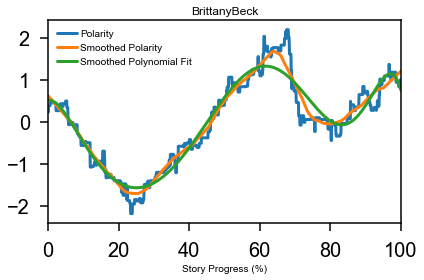

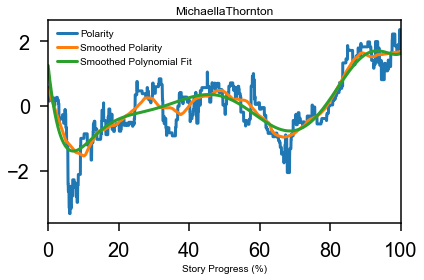

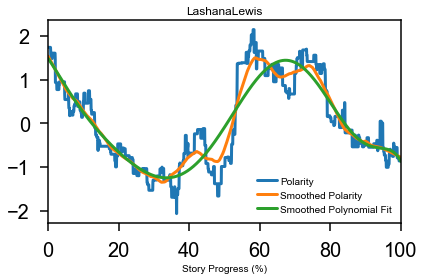

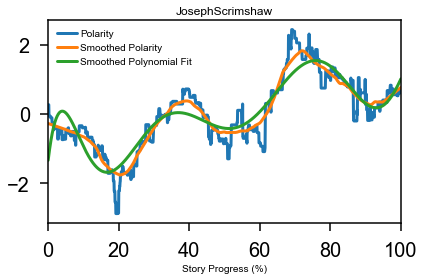

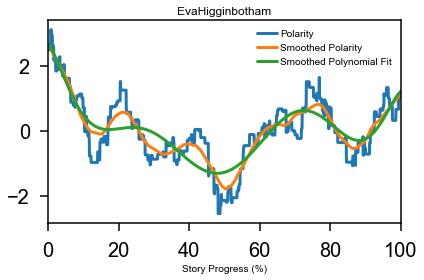

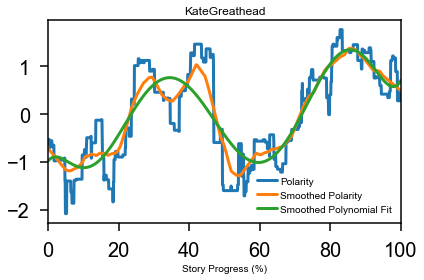

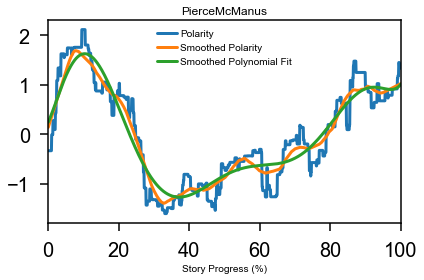

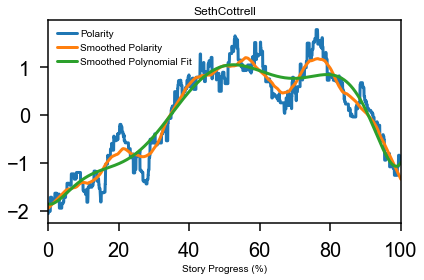

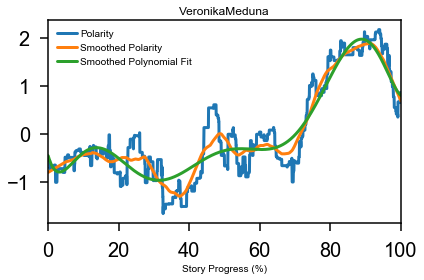

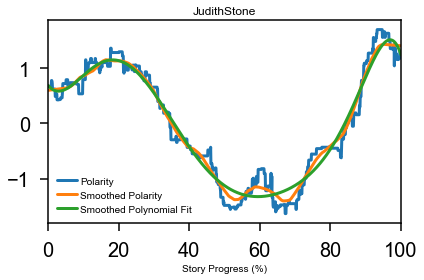

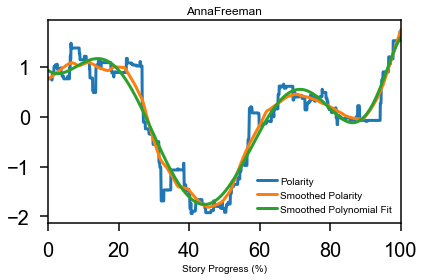

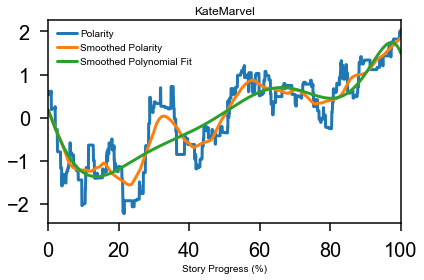

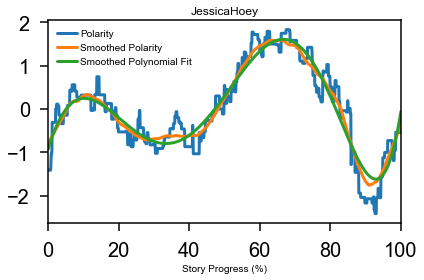

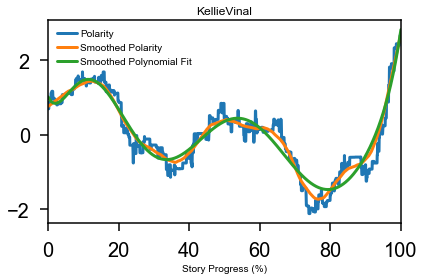

In [5]:
%matplotlib inline

for key, val in polyfit_dict.items():
    filename = f"csv/{key}.csv"
    results = np.genfromtxt(filename, delimiter=',', skip_header=1)

    # Normalize
    pol = results[:,1]
    pol_norm = (pol-np.mean(pol))/np.std(pol)

    # Smooth the data
    smooth_window = curve_fitting.odd(len(pol_norm)//10)
    smooth_pol = savgol_filter(pol_norm, smooth_window, 1)

    # Get percentage of story
    percent = results[:,0]/results[-1,0]*100

    sm_p = np.poly1d(val)


    plt.title(key)
    plt.plot(percent, pol_norm, label="Polarity")
    plt.plot(percent, smooth_pol, label="Smoothed Polarity")
    plt.plot(percent, sm_p(percent), label="Smoothed Polynomial Fit")
    plt.legend()
    plt.xlim([0,100])
    plt.xlabel("Story Progress (%)")
    plt.show()

OK, so looking at those I'm trying to pick out a couple that fit some of the known story arcs...

Rags to riches:
    
    ElisaSchaum
    
    VeronikaMeduna
    
    KateMarvel
    
    SimonDonner

Icarus:
    
    MonicaDunford
    
    LewLefton
    
    Anonymous

Man in hole:
    
    JohnTrumbo
    
    MattBaker
    
    LylTomlinson

In [6]:
names = ["ElisaSchaum",
         "VeronikaMeduna",
         "KateMarvel",
         "SimonDonner",
         "MonicaDunford",
         "LewLefton",
         "Anonymous",
         "JohnTrumbo",
         "MattBaker",
         "LylTomlinson"]

coeffs_array = np.zeros([len(names), 8 + 1])

for i, name in enumerate(names):
        coeffs_array[i,:] = polyfit_dict[name]

In [7]:
# OK so 9 variables is a little intimidating to try clustering with,
# so let's look at the last two coefficients -- these modify the constant
# and linear terms of the polynomial

X = np.copy(coeffs_array[:,-2:])

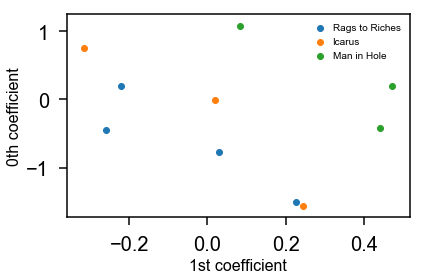

In [8]:
plt.scatter(X[:4,0], X[:4,1], label="Rags to Riches")
plt.scatter(X[4:7,0], X[4:7,1], label="Icarus")
plt.scatter(X[7:,0], X[7:,1], label="Man in Hole")
plt.legend()
plt.xlabel("1st coefficient", fontsize=16)
plt.ylabel("0th coefficient", fontsize=16)
plt.show()

In the cell below, I am following the example from:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


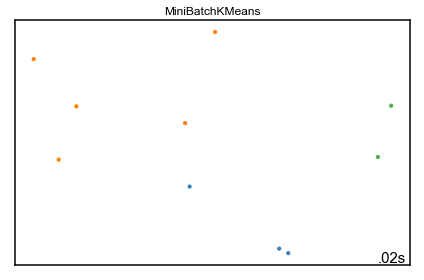

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


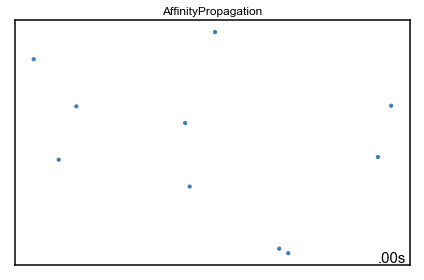

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


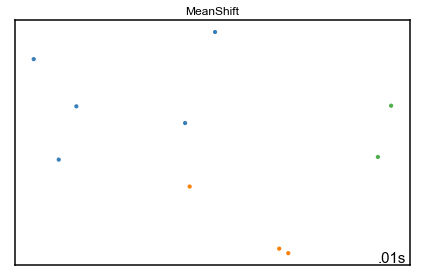

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


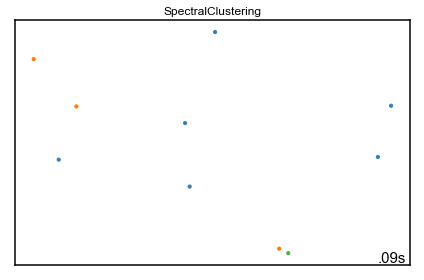

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


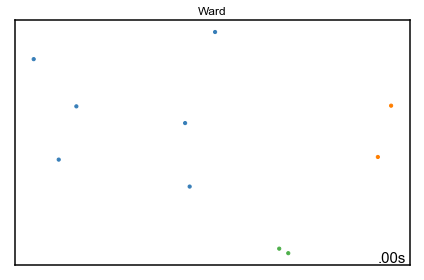

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


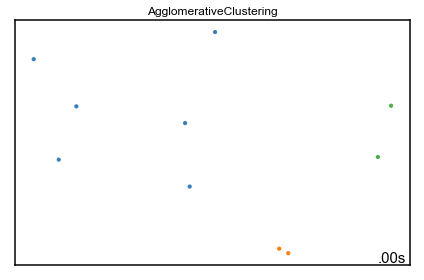

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


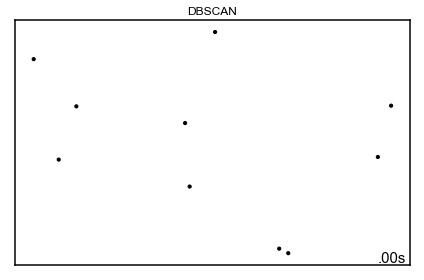

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


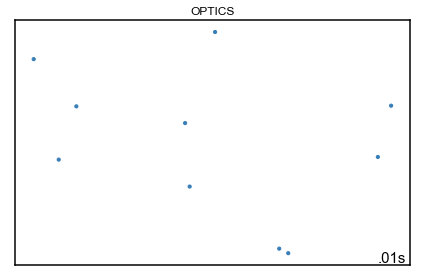

/Users/jennyfothergill/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


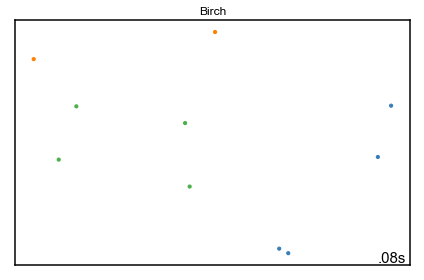

In [9]:
params = {'quantile': .3,
          'eps': .3,
          'damping': .9,
          'preference': -200,
          'n_neighbors': 5,
          'n_clusters': 3,
          'min_samples': 10,
          'xi': 0.05,
          'min_cluster_size': 0.1}

# normalize dataset for easier parameter selection
X = skl.preprocessing.StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = skl.neighbors.kneighbors_graph(
    X, 
    n_neighbors=params['n_neighbors'], 
    include_self=False
)

# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], 
    linkage='ward',
    connectivity=connectivity
)

spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors"
)

dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(
    min_samples=params['min_samples'],
    xi=params['xi'],
    min_cluster_size=params['min_cluster_size']
)

affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], 
    preference=params['preference']
)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", 
    affinity="cityblock",
    n_clusters=params['n_clusters'], 
    connectivity=connectivity
)

birch = cluster.Birch(n_clusters=params['n_clusters'])



clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('OPTICS', optics),
    ('Birch', birch),
)

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)


    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    #plt.xlim(-2.5, 2.5)
    #plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plt.title(name)
    plt.show()

OK, so the clustering seems to work alright, but clearly two coefficients from a polynomial fit with 9 coefficients is not enough to correctly cluster the data. Even the grouping in the first plot looks odd. Let's try with 3 coefficients.

<IPython.core.display.Javascript object>


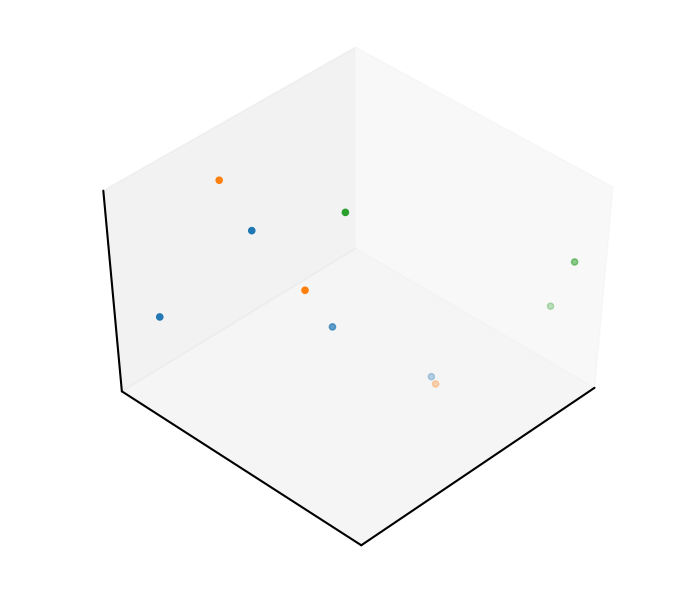

In [13]:
%matplotlib notebook

X = np.copy(coeffs_array[:,-3:])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:4,0], X[:4,1], X[:4,2], label="Rags to Riches")
ax.scatter(X[4:7,0], X[4:7,1], X[4:7,2], label="Icarus")
ax.scatter(X[7:,0], X[7:,1], X[7:,2], label="Man in Hole")

ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())

plt.show()

<IPython.core.display.Javascript object>


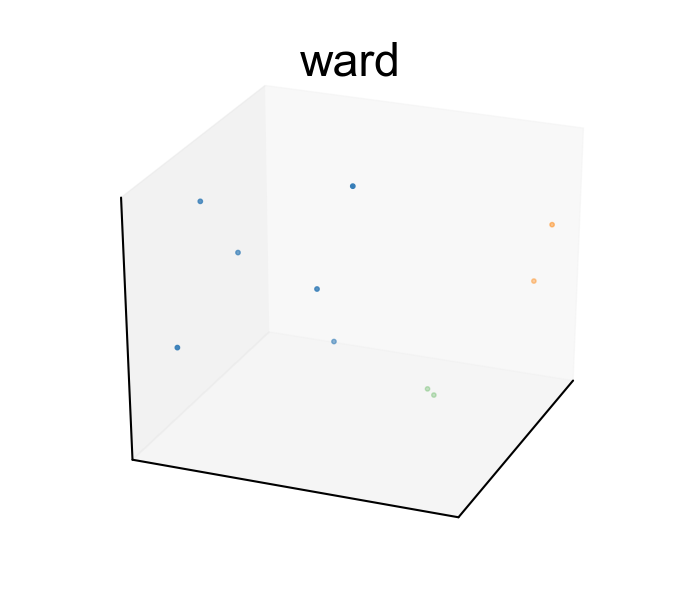

In [12]:
# Just going to try with ward agglomeration

params = {'quantile': .3,
          'eps': .3,
          'damping': .9,
          'preference': -200,
          'n_neighbors': 5,
          'n_clusters': 3,
          'min_samples': 10,
          'xi': 0.05,
          'min_cluster_size': 0.1}

# normalize dataset for easier parameter selection
X = skl.preprocessing.StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = skl.neighbors.kneighbors_graph(
    X, 
    n_neighbors=params['n_neighbors'], 
    include_self=False
)

# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], 
    linkage='ward',
    connectivity=connectivity
)

algorithm = ward
t0 = time.time()
algorithm.fit(X)
t1 = time.time()
if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)


colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:, 0], X[:, 1], X[:,2], s=10, color=colors[y_pred])

ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())

plt.title("ward")
plt.show()

In [16]:
# I think y_pred tells which cluster it thinks the data belongs to.
# In this case I specified 3 clusters (because I arbitrarily picked 
# out a couple of story shapes that looked like three of the notable
# shapes), and so it has assigned each pt to a cluster [0, 1, 2]

print(y_pred)

# With more than 3 parameters, we will no longer be able to visualize the 
# clustering on a plot, but we should be able to view the story arc clusters
# and see if they seem reasonable.

[0 0 0 2 0 2 0 1 1 0]


In [18]:
# Make array of all coefficients
X = np.zeros([len(authors), 8 + 1])

for i, name in enumerate(authors):
    X[i,:] = polyfit_dict[name]

In [19]:
params = {'quantile': .3,
          'eps': .3,
          'damping': .9,
          'preference': -200,
          'n_neighbors': 5,
          'n_clusters': 6,
          'min_samples': 10,
          'xi': 0.05,
          'min_cluster_size': 0.1}

# normalize dataset for easier parameter selection
X = skl.preprocessing.StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = skl.neighbors.kneighbors_graph(
    X, 
    n_neighbors=params['n_neighbors'], 
    include_self=False
)

# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], 
    linkage='ward',
    connectivity=connectivity
)

spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors"
)

dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(
    min_samples=params['min_samples'],
    xi=params['xi'],
    min_cluster_size=params['min_cluster_size']
)

affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], 
    preference=params['preference']
)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", 
    affinity="cityblock",
    n_clusters=params['n_clusters'], 
    connectivity=connectivity
)

birch = cluster.Birch(n_clusters=params['n_clusters'])



clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('OPTICS', optics),
    ('Birch', birch),
)

clusters = {}

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    clusters[name] = y_pred

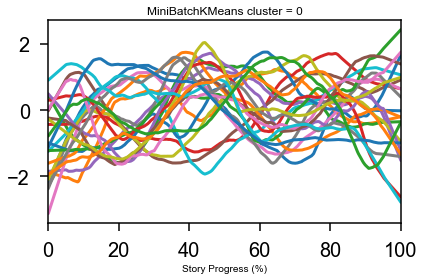

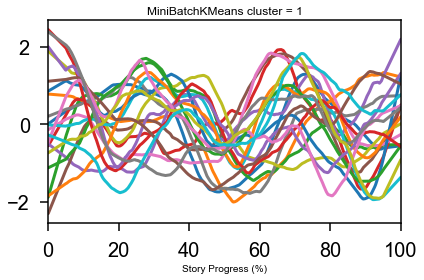

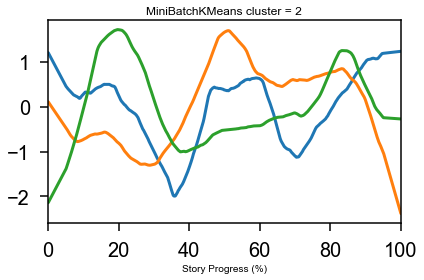

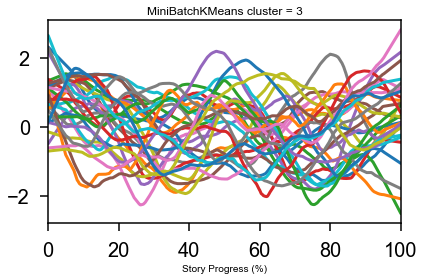

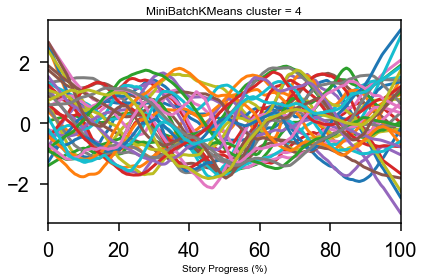

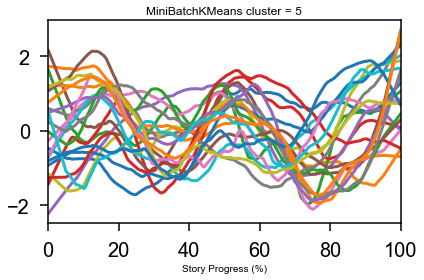

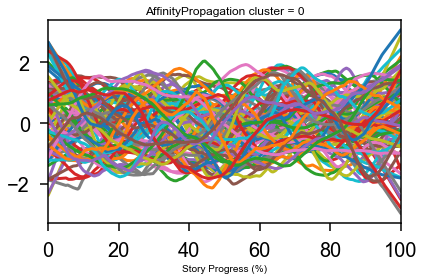

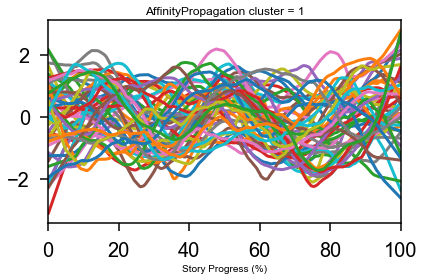

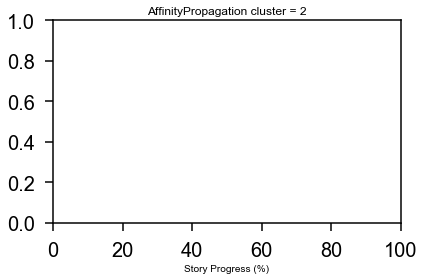

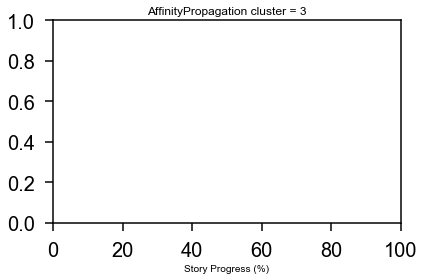

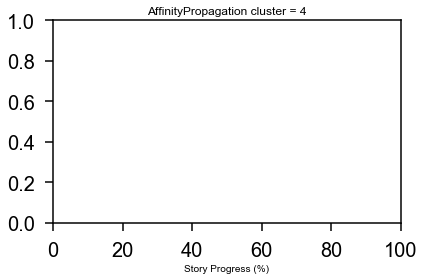

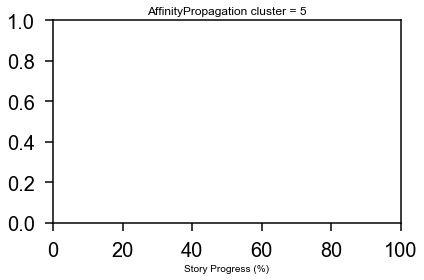

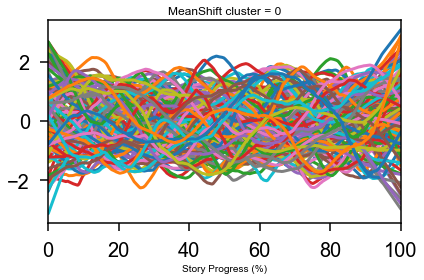

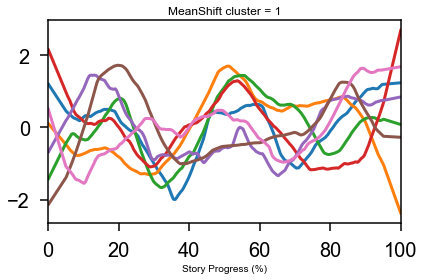

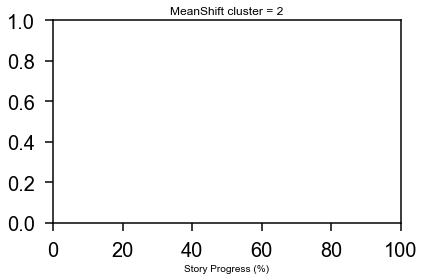

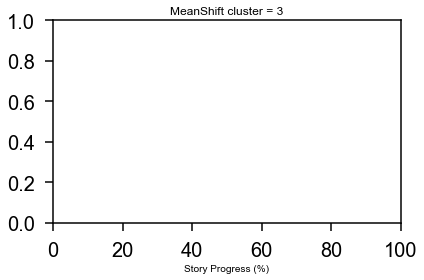

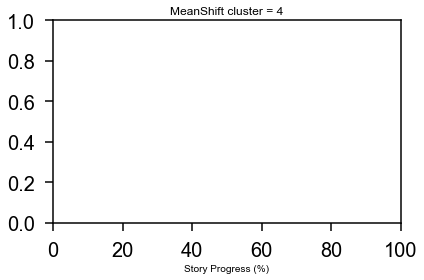

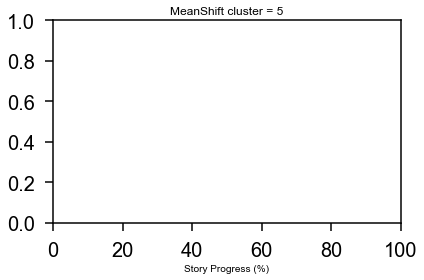

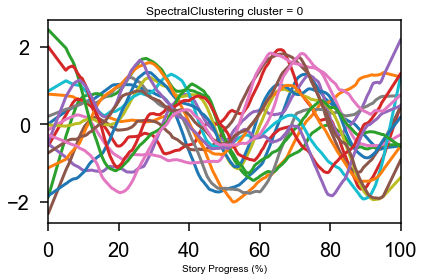

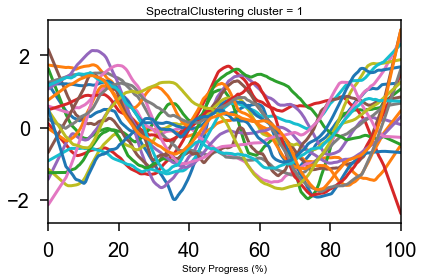

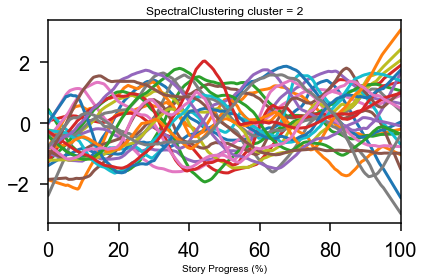

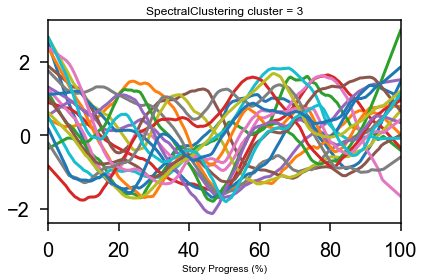

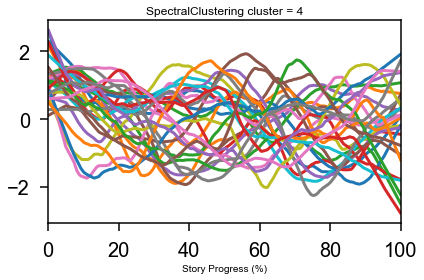

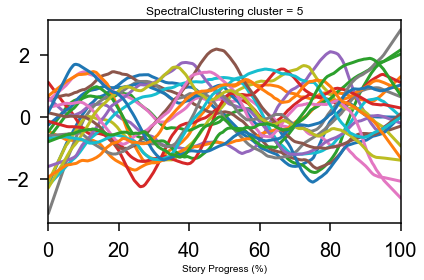

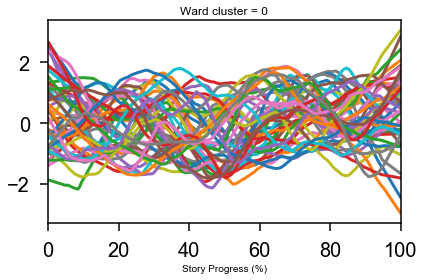

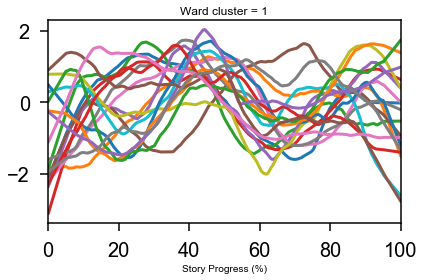

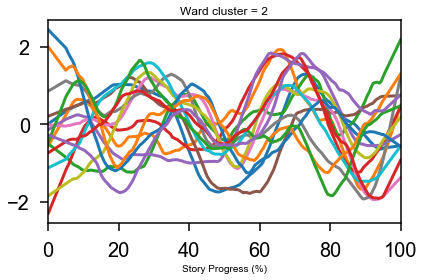

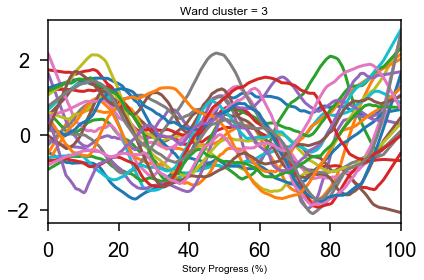

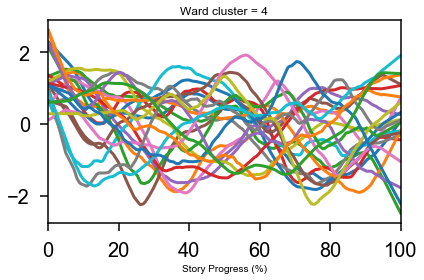

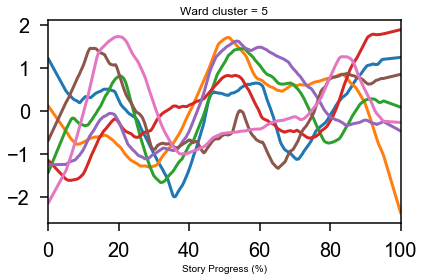

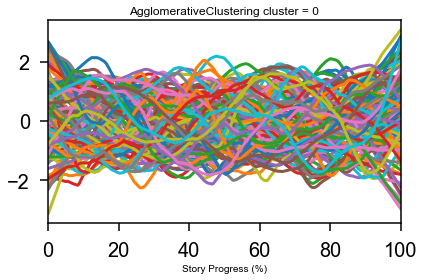

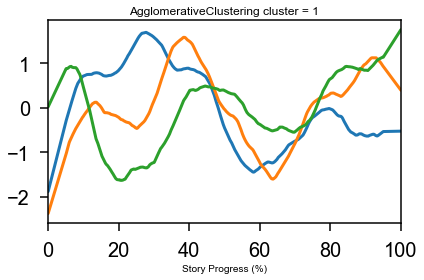

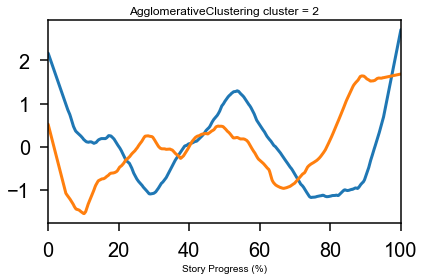

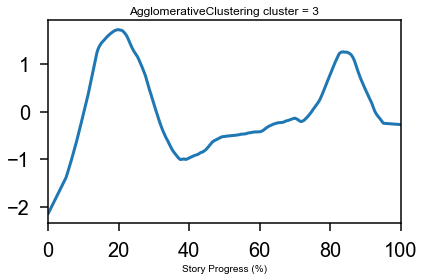

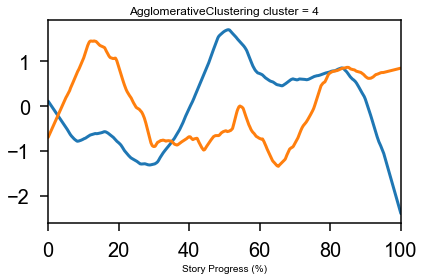

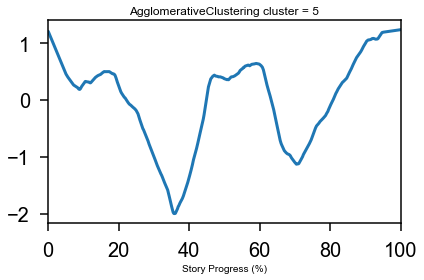

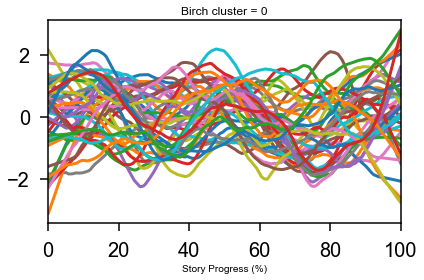

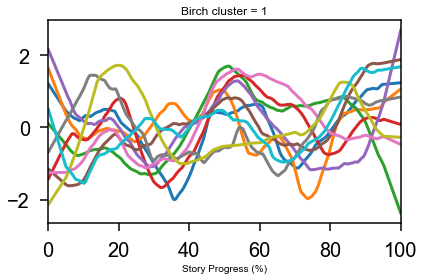

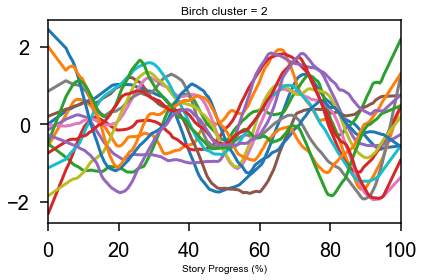

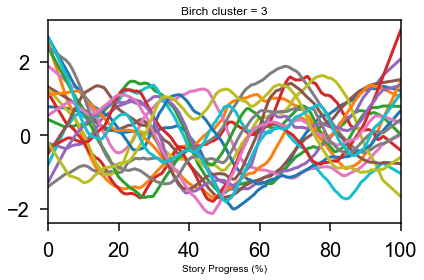

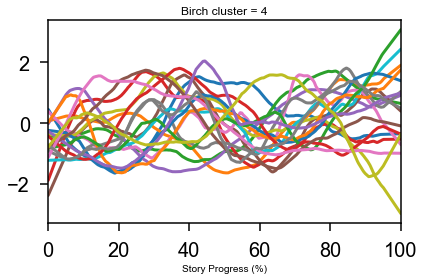

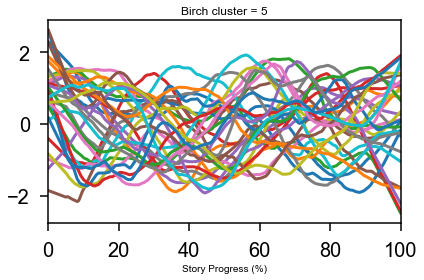

In [36]:
%matplotlib inline

methods = ["MiniBatchKMeans",
           "AffinityPropagation",
           "MeanShift",
           "SpectralClustering",
           "Ward",
           "AgglomerativeClustering",
           "Birch"]
     
authors = np.array(authors)
for method in methods:
    for num in range(6):
        for name in authors[np.where(clusters[method] == num)]:
            
            filename = f"csv/{name}.csv"
            results = np.genfromtxt(filename, delimiter=",", skip_header=1)
            
            # Normalize
            pol = results[:,1]
            pol_norm = (pol-np.mean(pol))/np.std(pol)
            
            # Smooth the data
            smooth_window = curve_fitting.odd(len(pol_norm)//10)
            smooth_pol = savgol_filter(pol_norm, smooth_window, 1)
            
            # Get percentage of story
            percent = results[:,0]/results[-1,0]*100
            
            coeffs = polyfit_dict[name]
            sm_p = np.poly1d(coeffs)
            
            
            #plt.plot(percent, pol_norm, label="Polarity")
            plt.plot(percent, smooth_pol, label="Smoothed Polarity")
            #plt.plot(percent, sm_p(percent), label="Smoothed Polynomial Fit")
        plt.title(f"{method} cluster = {num}")
        plt.xlim([0,100])
        plt.xlabel("Story Progress (%)")
        plt.show()